In [1]:
import stream_time_reversability as STR
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import tstrippy
import datetime
import multiprocessing as mp
from astropy import units as u
from astropy.coordinates import SkyCoord
import h5py
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
})

# design reverse integrability

In [9]:
path="./simulations/"
fnames=os.listdir("./simulations/")
fnames = [f for f in fnames if f.endswith('.hdf5') ]
fname = fnames[2]
myfile = h5py.File(path+fname, 'r')

In [31]:
streaminitial = myfile['streaminitial'][:]
hostorbit=myfile["hostorbit"][:]
hosttimestamps = myfile["timestamps"][:]
hostparams = myfile.attrs["hostparams"]
inithostperturber = [hosttimestamps, *hostorbit, *hostparams]
integrationparameters = myfile.attrs["integrationparameters"]
staticgalaxy=[myfile.attrs['potentialname'], myfile.attrs['potentialparams']]
streamfinal=myfile['streamfinal'][:]
args = [streamfinal, staticgalaxy, integrationparameters, inithostperturber]
stream_retrace, tesc, timestamps_retrace, comptime = STR.leapfrogtofinalpositions_stream_retrace(args)

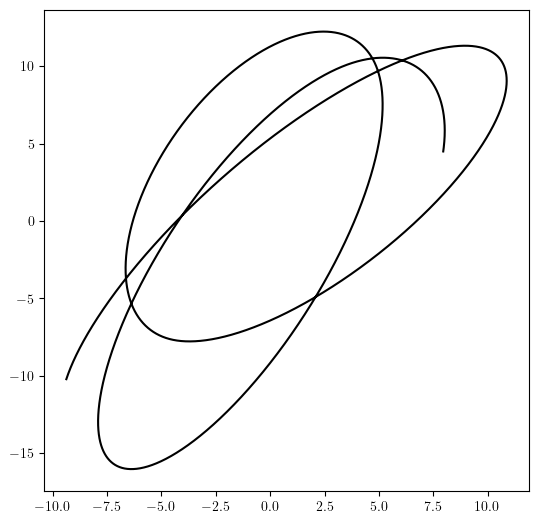

In [78]:
updex = -1000
downdex = 6
fig,axis= plt.subplots(1,1,figsize=(8.25-2,8.25-2))
axis.plot(hostorbit[0,downdex:updex], hostorbit[1,downdex:updex], 'k-', label='Host orbit')

[]

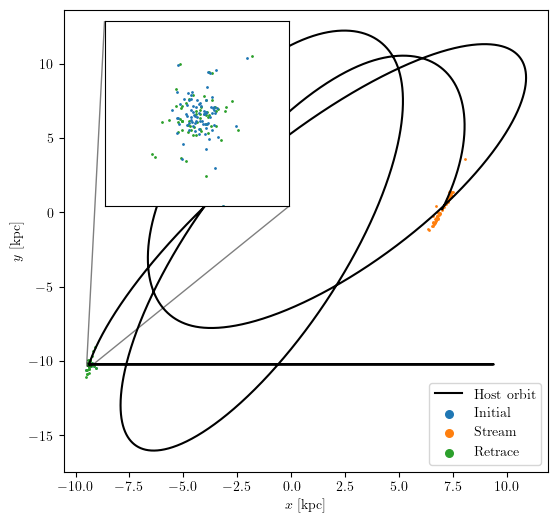

In [ ]:
fig,axis= plt.subplots(1,1,figsize=(8.25-2,6))
axis.plot(hostorbit[0], hostorbit[1], 'k-', label='Host orbit')
axis.scatter(hostorbit[0,0] + streaminitial[0], hostorbit[1,0]  + streaminitial[1], s=1, c='C0', label='Initial')
axis.scatter(streamfinal[0], streamfinal[1], s=1, c='C1', label='Stream')
axis.scatter(stream_retrace[0], stream_retrace[1], s=1, c='tab:green', label='Retrace')
# add a subplot that zooms on the retrace positions
axins = axis.inset_axes([0.075, 0.575, 0.4, 0.4])  # [x0, y0, width, height]
axins.scatter(stream_retrace[0], stream_retrace[1], s=1, c='tab:green', label='Stream retrace positions')
axins.scatter(hostorbit[0,0] + streaminitial[0], hostorbit[1,0]  + streaminitial[1], s=1, c='C0', label='Stream initial positions')
axins.set_aspect('equal', adjustable='box')
# only do a couple characteristic radii
radius = .1
axins.set_xlim(hostorbit[0,0] + - radius, hostorbit[0,0]  + radius)
axins.set_ylim(hostorbit[1,0] + - radius, hostorbit[1,0]  + radius)
axis.legend(loc='lower right')
# Add indicator lines from the main plot to the inset
axis.indicate_inset_zoom(axins, edgecolor="black")

# Make markers in legend bigger
legend = axis.legend(loc='lower right')
for handle in legend.legend_handles:
    handle._sizes = [30]

# Also make markers in the inset legend bigger if needed
axis.set_xlabel(r'$x$ [kpc]')
axis.set_ylabel(r'$y$ [kpc]')
axins.set_xticks([])
axins.set_yticks([])

In [3]:
# pseduo code

# slip the sign of the velocities for the host when we change directions 

# no need to reorient the array becuase the new func to coordinate the indicies is good

# no need to flip the sign of the velocities for the stream, setbackwardorbit does that

# so load in the orbit

# take the integration parameters

# load in the stream particles at the end

# integrate backward and see where we land 

In [3]:
MWparams = tstrippy.Parsers.pouliasis2017pii()
dtfactor = 1/100
staticgalaxy = ["pouliasis2017pii", MWparams]
G = MWparams[0]
M = 1e5
a = 5e-3
NP = int(1e2)
aplum = tstrippy.ergodic.convertHalfMassRadiusToPlummerRadius(a)
tau = STR.plummer_dynamical_time([G,M,a])

In [4]:
targetGC = "NGC6760"
initialkinematics = STR.pick_GC_get_kinematics(targetGC)

In [5]:
integrationparameters = STR.prepare_integration_arguments(currenttime=currenttime,
                                                          integrationtime=integrationtime,
                                                          tdyn=tau,
                                                          alpha=dtfactor)

print("nsteps", integrationparameters[-1])
integrationparameters = list(integrationparameters)


nsteps 2048


In [6]:
args = initialkinematics, staticgalaxy, integrationparameters
orbit, timestamps, comptime = STR.integrate_host_orbit_back(args)

In [7]:
integrationparameters

[0, np.float64(4.882812500000001e-06), 2048]

In [8]:
inithostperturber = [timestamps, *orbit, G, M, aplum ]
xp,yp,zp,vxp,vyp,vzp = tstrippy.ergodic.isotropicplummer(G,M,a,NP)
integrationparameters_stream = [timestamps[0],*integrationparameters[1:]]
initialkinematics_stream = [xp+orbit[0,0], yp+orbit[1,0], zp+orbit[2,0], vxp+orbit[3,0], vyp+orbit[4,0], vzp+orbit[5,0]]

In [9]:
streaminit = np.array([xp, yp, zp, vxp, vyp, vzp]).T + orbit[:,0]

In [10]:
args_stream = initialkinematics_stream, staticgalaxy, integrationparameters_stream, inithostperturber
stream,tesc, comptime = STR.leapfrogtofinalpositions_stream(args_stream)
print(f"Stream generation took {comptime} seconds")

Stream generation took 0.137761 seconds


In [11]:
# dx,dy,dz,dvx,dvy,dvz=(stream - orbit[:,0][:,np.newaxis]).T
dx,dy,dz,dvx,dvy,dvz=(stream - orbit[:,-1][:,np.newaxis])
dr = np.sqrt(dx**2 + dy**2 + dz**2)
phi0 = -G*M/(dr**2 + aplum**2)**(1/2)
T0 = (1/2) * (dvx**2 + dvy**2 + dvz**2) 
E0 = phi0 + T0

In [12]:
NSTEP = int(1e6)
NP = int(1e5)
Nc = 80e-9
Nmc = 50
NGC = 165
comptime=Nmc*NGC*NSTEP*NP*Nc * u.s
comptime.to(u.day) / 100

<Quantity 7.63888889 d>

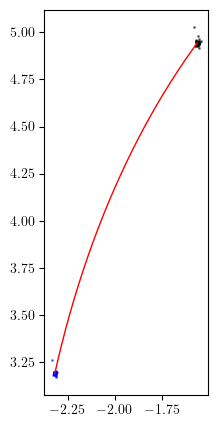

In [13]:
fig,axis= plt.subplots(1,1,figsize=(8.25-2,5))
axis.scatter(stream[0], stream[1], s=1, c='k', alpha=0.5)
axis.scatter(xp+orbit[0,0], yp+orbit[1,0], s=1, c='b', alpha=0.5, label='Stream particles')
axis.plot(orbit[0],orbit[1], c='r', lw=1, label='Host orbit')
axis.set_aspect('equal')

# Computation time

$$C(N_p, N_{\text{Steps}}) = A \cdot N_p^\alpha \cdot N_{\text{Steps}}^\beta $$

$$\log C = \log A + \alpha \log N_p + \beta \log N_{\text{Steps}} $$

$$\log C = \log A + \alpha \log N_p + \beta \log N_{\text{Steps}} $$


In [14]:
import os 
targetGC = 'NGC6760'
integrationtime = 1  # in dynamical time units
NPs = np.logspace(1,3,3, dtype=int)  # number of particles for the stream
alphas = np.logspace(1,-2,3)
Nc = 80e-9 # mean time per single step 

In [15]:
path="./simulations/"
fnames=os.listdir("./simulations/")
fnames = [f for f in fnames if f.endswith('.hdf5') ]
NPs = [ ]
NSTEPS = []
comp = []
for i in range(0,len(fnames)):
    myfile=h5py.File(path+fnames[i], 'r')
    NSTEP = myfile['hostorbit'].shape[1]
    NP = myfile['streamfinal'].shape[1]
    comptimestream = myfile['comptimestream'][()]

    NPs.append(NP)
    NSTEPS.append(NSTEP)
    comp.append(comptimestream)

NPs = np.array(NPs)
NSTEPS = np.array(NSTEPS)
comp = np.array(comp)

In [16]:
np.mean(comp/NPs/NSTEPS)

np.float64(5.201160565677789e-06)

In [17]:
logNPS = np.log10(NPs)
logNSTEPS = np.log10(NSTEPS)
logcomp = np.log10(comp)

In [18]:
A = np.vstack([np.ones_like(logNPS), logNPS, logNSTEPS]).T
# least squares fit
coeffs, residuals, rank, s = np.linalg.lstsq(A, logcomp, rcond=None)
logA, alpha, beta = coeffs

In [19]:
print(f"Fit: log C = {logA:.2f} + {alpha:.2f} log Np + {beta:.2f} log Nsteps")
print(f"Fit: C = 10^{logA:.2f} * Np^{alpha:.2f} * Nsteps^{beta:.2f}")

Fit: log C = -6.83 + 1.48 log Np + 0.99 log Nsteps
Fit: C = 10^-6.83 * Np^1.48 * Nsteps^0.99


In [20]:
cmax = np.max(comp)
cmin = np.min(comp)
norm = mpl.colors.LogNorm(vmin=cmin, vmax=cmax)
cmap = mpl.cm.rainbow
colors = cmap(norm(comp))

/var/folders/vt/72vlp8hj577dnzr1gl35j41c0000gn/T/ipykernel_97620/3082384356.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axis.scatter(NSTEPS, NPs, c=colors, marker="s", s=100, cmap='viridis', alpha=0.7)


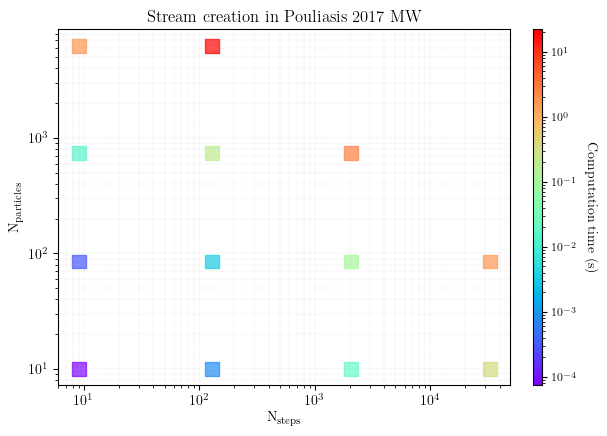

In [21]:
fig=plt.figure(figsize=(8.25-2,5))
gs = fig.add_gridspec(1, 2, width_ratios=[1, 1/50],hspace=0.1, wspace=0.1)
axis = fig.add_subplot(gs[0, 0])
cax = fig.add_subplot(gs[0, 1])
axis.grid(True, which='both', linestyle='--', linewidth=0.1)
axis.scatter(NSTEPS, NPs, c=colors, marker="s", s=100, cmap='viridis', alpha=0.7)
axis.set_xlabel(r'$\mathrm{N}_{\mathrm{steps}}$')
axis.set_ylabel(r'$\mathrm{N}_{\mathrm{particles}}$')
axis.set_title(r'$\mathrm{Stream~creation~in~Pouliasis~2017~MW}$')
axis.set_xscale('log')
axis.set_yscale('log')
axis.set_aspect('equal')
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cax)
cbar.set_label(r'$\mathrm{Computation~time~(s)}$', rotation=270, labelpad=15)
cbar.ax.tick_params(labelsize=8)
# make the colorbar the same height as the plot
# Adjust colorbar position to match plot height
cbar.ax.set_position([cbar.ax.get_position().x0, 
                     axis.get_position().y0, 
                     cbar.ax.get_position().width, 
                     axis.get_position().height])

In [69]:
NPs.max()

np.int64(3162)